<a href="https://colab.research.google.com/github/rliu7926/weinstein-ligo-research/blob/main/3.4%20SNR%20Expectation%20vs.%20Noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q 'PyCBC==1.15.3' 'lalsuite==6.66'
! pip install astropy

from astropy.cosmology import FlatLambdaCDM, Planck18, z_at_value
import numpy as np
import pylab

import astropy.units as u
import matplotlib.pyplot as plt

from pycbc.waveform import get_td_waveform

import pycbc
import pycbc.noise
import pycbc.psd

from random import randint
from pycbc.filter import matched_filter
from pycbc.psd import interpolate, inverse_spectrum_truncation

import pandas as pd
from pycbc.types import TimeSeries

import seaborn as sns

     |████████████████████████████████| 3.1MB 7.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 28.5MB 112kB/s 
     |████████████████████████████████| 1.6MB 47.1MB/s 
     |████████████████████████████████| 890kB 32.1MB/s 
     |████████████████████████████████| 81kB 11.1MB/s 
     |████████████████████████████████| 61kB 9.3MB/s 
     |████████████████████████████████| 61kB 8.2MB/s 
     |████████████████████████████████| 3.2MB 28.5MB/s 


In [ ]:
## Taken from notebook 3.1 (updated redshift and duration)

def create_waveform(mass1, mass2, resolution, frequencybound, distance, cosmology=Planck18):

  redshift = 1 + z_at_value(cosmology.comoving_distance, distance * u.Mpc)
  
  fbound = frequencybound * redshift

  waveform, waveform_cross = get_td_waveform(approximant="SEOBNRv4_opt",
                                             mass1=mass1,
                                             mass2=mass2,
                                             delta_t=resolution/redshift,
                                             f_lower=fbound)
  
  waveform_amplitude = [0.0] * len(waveform)
  waveform_time = [0.0] * len(waveform)

  for i in range(len(waveform)):
    waveform_amplitude[i] = waveform[i]
    waveform_time[i] = waveform.sample_times[i]

  waveform_amplitude = [i/distance for i in waveform_amplitude]
  waveform_time = [i*redshift for i in waveform_time]

  waveform_amplitude = np.array(waveform_amplitude)
  waveform_time = np.array(waveform_time)

  return waveform_amplitude, waveform_time

In [ ]:
## Taken from notebook 3.2 (SNR expectation value without any noise)

def expectation_SNR(mass1, mass2, templatemass1, templatemass2, resolution, psdresolution, lowfreq, distance, psd, cosmology=Planck18):

  ## Create waveform 

  gwamp, gwtime = create_waveform(mass1=mass1, mass2=mass2, resolution=resolution, frequencybound=lowfreq, distance=distance, cosmology=cosmology)
  gwsignal = TimeSeries(gwamp, delta_t=resolution)
  gwsignalfreq = gwsignal.to_frequencyseries(delta_f = psdresolution)


  ## Create PSD 

  flen = int((1 / resolution) / (2 * psdresolution)) + 1

  if psd == 'aLIGOAPlusDesignSensitivityT1800042':
    psdfreq = pycbc.psd.aLIGOAPlusDesignSensitivityT1800042(flen, psdresolution, lowfreq)
  
  if psd == 'aLIGODesignSensitivityP1200087':
    psdfreq = pycbc.psd.aLIGODesignSensitivityP1200087(flen, psdresolution, lowfreq)

  if psd == 'CosmicExplorerP1600143':
    psdfreq = pycbc.psd.CosmicExplorerP1600143(flen, psdresolution, lowfreq)


  ## Create template

  template, _ = get_td_waveform(approximant="SEOBNRv4_opt", mass1=templatemass1, mass2=templatemass2, delta_t=resolution, f_lower=lowfreq)
  templatefreq = template.to_frequencyseries(delta_f = psdresolution)


  ## Calculate SNR

  gwdata = gwsignalfreq + psdfreq
  snr = matched_filter(template=templatefreq, data=gwdata, psd=psdfreq, low_frequency_cutoff=lowfreq)

  print("The signal-to-noise ratio is: {}".format(max(abs(snr))))

  return(max(abs(snr)))
  

In [ ]:
## Taken from notebook 2.2 (SNR value with noise)

def determine_SNR(mass1, mass2, waveformmass1, waveformmass2, resolution, frequencybound, psdresolution, distance, noise, noisetime, graph = "F"):

  gwamp, gwtime = create_waveform(mass1, mass2, resolution, frequencybound, distance)

  # Generate the frequency series PSD

  samples = int(4096 / psdresolution) + 1

  designpsd = pycbc.psd.from_string(psd_name = noise,
                                         length = samples,
                                         delta_f = psdresolution, 
                                         low_freq_cutoff = frequencybound)

  # Generate [noisetime] seconds of Gaussian noise at [1/resolution] Hz

  timesamples = int(noisetime / resolution)
  gaussiannoise = pycbc.noise.gaussian.noise_from_psd(length = timesamples, 
                                                      delta_t = resolution,
                                                      psd = designpsd,
                                                      seed = None)
  
  # Resize GW signal to the length of the random noise sample

  timeshift = randint(0, len(gaussiannoise)-len(gwamp)) # Add a random timeshift
  gwamp = np.append([0] * timeshift, gwamp) # Append zeroes before the wave
  gwamp = np.append(gwamp, [0] * (len(gaussiannoise)-len(gwamp))) # Append zeroes after the wave 
  gwtime = gaussiannoise.sample_times

  ## Add the waveform to the generated noise

  gwnoise = gaussiannoise + gwamp

  ## Calculate the SNR time series 

  waveform_template, waveform_template_cross = get_td_waveform(approximant="SEOBNRv4_opt",
                                                               mass1=waveformmass1,
                                                               mass2=waveformmass2,
                                                               delta_t=resolution, 
                                                               f_lower=frequencybound)

  waveform_template.resize(len(gaussiannoise))
  waveform_template = waveform_template.cyclic_time_shift(waveform_template.start_time)

  ## Calculate and plot the SNR
  
  psd = gwnoise.psd(4)
  psd = interpolate(psd, gwnoise.delta_f)
  psd = inverse_spectrum_truncation(psd, 4*gwnoise.sample_rate, low_frequency_cutoff=frequencybound)

  gwsnr = matched_filter(template=waveform_template,
                         data=gwnoise,
                         psd = psd,
                         low_frequency_cutoff=frequencybound)
  
  if graph == "T":
    pylab.figure()
    pylab.plot(gwsnr.sample_times, abs(gwsnr))

  gwsnrpeak = abs(gwsnr).numpy().argmax()
  gwsnrpeakvalue = gwsnr[gwsnrpeak]
  gwsnrpeaktime = gwsnr.sample_times[gwsnrpeak]

  print("A signal was found at {} s with SNR {}.".format(gwsnrpeaktime, abs(gwsnrpeakvalue)))
  print("The redshifted waveform was inserted at time {} s.".format(timeshift*resolution))

  return(abs(gwsnrpeakvalue), gwsnrpeaktime, timeshift*resolution)


In [ ]:
## Compare distribution of SNR with noise and SNR expectation 

snr30 = [0] * 500
snr50 = [0] * 500
snr75 = [0] * 500

snr30exp = expectation_SNR(30, 30, 30, 30, 1.0/1024, 1.0/16, 20, 1000, "aLIGODesignSensitivityP1200087")
snr50exp = expectation_SNR(50, 50, 50, 50, 1.0/1024, 1.0/16, 20, 1000, "aLIGODesignSensitivityP1200087")
snr75exp = expectation_SNR(75, 75, 75, 75, 1.0/1024, 1.0/16, 20, 1000, "aLIGODesignSensitivityP1200087")

snrlist = [snr30, snr50, snr75]
masslist = [30, 50, 75]

snrexplist = [snr30exp, snr50exp, snr75exp]

for s in range(len(snrlist)): 
  for i in range(len(snrlist[s])):

    snrlist[s][i], time1, time2 = determine_SNR(mass1=masslist[s], mass2=masslist[s], waveformmass1=masslist[s], waveformmass2=masslist[s],
                                  resolution=1.0/1024, psdresolution=1.0/16, frequencybound=20, distance=1000,
                                  noise="aLIGODesignSensitivityP1200087", noisetime=32, graph='F')
    
    print("Mass: {}, Iteration: {}, SNR: {}".format(masslist[s], i, snrlist[s][i]))

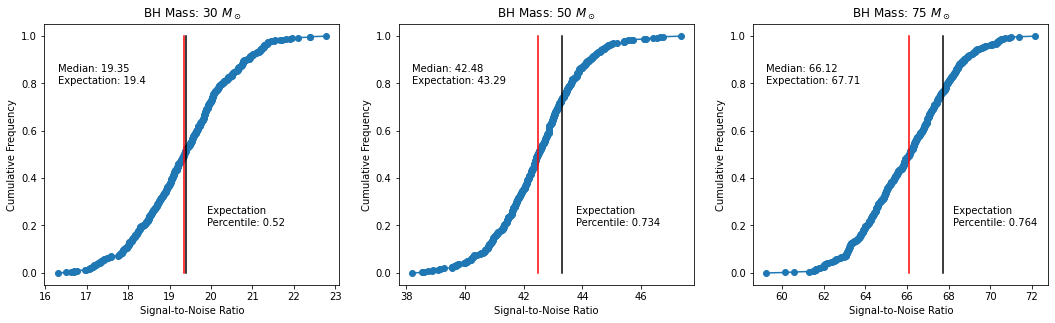

In [ ]:
fig = plt.figure()

for i in range(len(snrlist)):

  plt.subplot(1, len(snrlist), i+1)

  x = np.sort(snrlist[i])
  y = np.arange(len(x)) / float(len(x))

  plt.plot(x, y, marker = "o")

  linex = [snrexplist[i], snrexplist[i]]
  liney = [0.0, 1.0]

  plt.plot(linex, liney, color="black")

  median = x[int(len(x)/2)]
  medianx = [median, median]
  mediany = [0.0, 1.0]

  plt.plot(medianx, mediany, color="red")

  percentile = np.count_nonzero(snrlist[i] < snrexplist[i]) / len(snrlist[i])

  pylab.xlabel("Signal-to-Noise Ratio")
  pylab.ylabel("Cumulative Frequency")
  pylab.title("BH Mass: {} $M_\odot$".format(masslist[i]))
  plt.text(x[0], 0.8, "Median: {}\nExpectation: {}".format(round(median, 2), round(snrexplist[i], 2)))
  plt.text(snrexplist[i]+0.5, 0.2, "Expectation \nPercentile: {}".format(percentile))

fig.set_figheight(4.8)
fig.set_figwidth(18)

  

In [ ]:
## Look at spread of SNR over multiple distances, in comparison with the expectation SNR

distances = np.arange(1000, 10000, 50)

snrexpectation = [0] * len(distances)

for i in range(len(distances)):
  snrexpectation[i] = expectation_SNR(mass1=30, mass2=30, templatemass1=30, templatemass2=30,
                                      resolution=1.0/1024, psdresolution=1.0/16, lowfreq=20,
                                      distance = distances[i], psd='aLIGODesignSensitivityP1200087')
  print("Distance: {}, SNR: {}".format(distances[i], snrexpectation[i]))


In [ ]:
distances = np.arange(1000, 10000, 50)
snractual = np.zeros(shape=(len(distances), 500))

for i in range(len(distances)):
  for j in range(len(snractual[i])):
    snractual[i][j], time1, time2 = determine_SNR(mass1=30, mass2=30, waveformmass1=30, waveformmass2=30, 
                                    resolution=1.0/1024, psdresolution=1.0/16, frequencybound=20,
                                    distance=distances[i], noise='aLIGODesignSensitivityP1200087', noisetime=16, graph='F')
    print("Distance: {}, Trial: {}, SNR: {}".format(distances[i], j, snractual[i][j]))

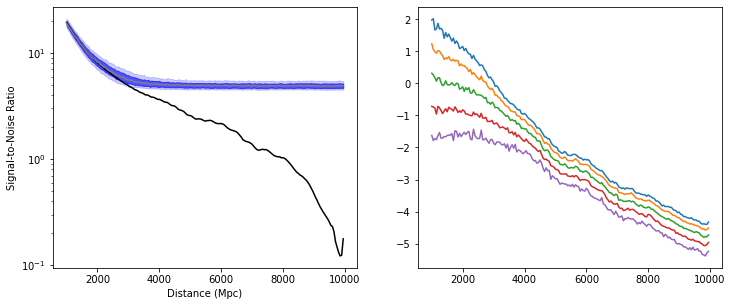

In [ ]:
snractual10, snractual25, snractual50, snractual75, snractual90 = ([0] * len(distances) for i in range(5))

for i in range(len(snractual)):
  snractual[i] = np.sort(snractual[i])

for i in range(len(distances)):
  snractual10[i] = snractual[i][50]
  snractual25[i] = snractual[i][125]
  snractual50[i] = snractual[i][250]
  snractual75[i] = snractual[i][375]
  snractual90[i] = snractual[i][450]

diff10, diff25, diff50, diff75, diff90 = ([0] * len(snrexpectation) for i in range(5))
for i in range(len(distances)):
  diff10[i] = snrexpectation[i] - snractual10[i]
  diff25[i] = snrexpectation[i] - snractual25[i]
  diff50[i] = snrexpectation[i] - snractual50[i]
  diff75[i] = snrexpectation[i] - snractual75[i]
  diff90[i] = snrexpectation[i] - snractual90[i]

fig, axs = plt.subplots(1, 2, figsize=(12,4.8))

axs[0].plot(distances, snrexpectation, color='black')
axs[0].plot(distances, snractual50, color='gray')
axs[0].fill_between(distances, snractual10, snractual90, facecolor='blue', color='blue', alpha=0.20)
axs[0].fill_between(distances, snractual25, snractual75, facecolor='blue', color='blue', alpha=0.60)

axs[0].set_xlabel("Distance (Mpc)")
axs[0].set_ylabel("Signal-to-Noise Ratio")
axs[0].set_yscale('log')

axs[1].plot(distances, diff10)
axs[1].plot(distances, diff25)
axs[1].plot(distances, diff50)
axs[1].plot(distances, diff75)
axs[1].plot(distances, diff90)

In [ ]:
## Determine when the SNR of noise masks that of the actual waveform

distances = np.arange(100, 10000, 100)
snrvalues, snrtimes, actualtimes = (np.zeros(shape=(len(distances), 500)) for i in range(3))

for i in range(len(distances)):
  for j in range(len(snrvalues[i])):

    snrvalues[i][j], snrtimes[i][j], actualtimes[i][j] = determine_SNR(mass1=30, mass2=30, waveformmass1=30, waveformmass2=30,
                                                                       resolution=1.0/1024, psdresolution=1.0/16, frequencybound=20,
                                                                       distance=distances[i], noise='aLIGODesignSensitivityP1200087', noisetime=16)
    print(i, j)

Streaming output truncated to the last 5000 lines.
The redshifted waveform was inserted at time 13.3466796875 s.
95 333
A signal was found at 15.4033203125 s with SNR 4.604605361254223.
The redshifted waveform was inserted at time 7.1259765625 s.
95 334
A signal was found at 15.4482421875 s with SNR 4.954560165368322.
The redshifted waveform was inserted at time 1.97265625 s.
95 335
A signal was found at 0.9189453125 s with SNR 5.362671557017798.
The redshifted waveform was inserted at time 10.5234375 s.
95 336
A signal was found at 11.673828125 s with SNR 4.950519379224124.
The redshifted waveform was inserted at time 12.3955078125 s.
95 337
A signal was found at 15.7880859375 s with SNR 4.824209621036114.
The redshifted waveform was inserted at time 12.2841796875 s.
95 338
A signal was found at 0.5380859375 s with SNR 5.054892980680175.
The redshifted waveform was inserted at time 1.595703125 s.
95 339
A signal was found at 0.111328125 s with SNR 4.892268873902546.
The redshifted wav

Text(0, 0.5, 'Signal Time')

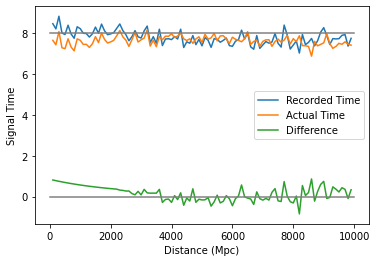

In [ ]:
snrtimeavg, actualtimeavg, diff = ([0] * len(distances) for i in range(3))

for i in range(len(distances)): 
  snrtimeavg[i] = np.mean(snrtimes[i])
  actualtimeavg[i] = np.mean(actualtimes[i])
  diff[i] = snrtimeavg[i] - actualtimeavg[i]

pylab.plot(distances, snrtimeavg)
pylab.plot(distances, actualtimeavg)
pylab.plot(distances, diff)
pylab.legend(labels=['Recorded Time', 'Actual Time', 'Difference'])

x = [0, 10000]
y1 = [8, 8]
y2 = [0, 0]
pylab.plot(x, y1, color='gray')
pylab.plot(x, y2, color='gray')
pylab.xlabel("Distance (Mpc)")
pylab.ylabel("Signal Time")